In [16]:
from gensim.models import Word2Vec
import pandas as pd
import numpy as np
import nltk
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt

nltk.download('punkt')
nltk.download('wordnet')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Augustin\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Augustin\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [17]:
# Chargement du dataset
data = pd.read_csv('data.csv')

# Suppression des lignes sans synopsis ou genres
data.dropna(subset=['overview', 'genre'], inplace=True)
data.reset_index(drop=True, inplace=True)

# Filtrage des données (on garde seulement les colonnes qui nous intéressent)
sorted_data = data[['original_title', 'overview', 'genre']]
filtered_data = sorted_data[sorted_data['overview'].str.len() > 10]

In [18]:
# Tokenisation et lemmatisation avec NLTK
lemmatizer = WordNetLemmatizer()

def preprocess_text(text):
    tokens = word_tokenize(text)
    lemmatized_tokens = [lemmatizer.lemmatize(token.lower()) for token in tokens]
    return lemmatized_tokens

In [19]:
# Diviser les données en ensemble d'entraînement et ensemble de test
X_train, X_test, y_train, y_test = train_test_split(filtered_data['overview'], filtered_data['genre'], test_size=0.2, random_state=42)

In [20]:
# Entraîner le modèle Word2Vec seulement sur l'ensemble d'entraînement
train_tokens = X_train.apply(preprocess_text)
model = Word2Vec(sentences=train_tokens, vector_size=100, window=5, min_count=1, workers=4)

In [21]:
# Transformer les données d'entraînement et de test en embeddings
X_train_embeddings = np.array([np.mean([model.wv[word] for word in doc if word in model.wv] or [np.zeros(model.vector_size)], axis=0) for doc in train_tokens])
X_test_embeddings = np.array([np.mean([model.wv[word] for word in doc if word in model.wv] or [np.zeros(model.vector_size)], axis=0) for doc in X_test.apply(preprocess_text)])

In [22]:
# Entraîner le modèle de classification sur l'ensemble d'entraînement
clf = RandomForestClassifier(n_estimators=100, random_state=42)
clf.fit(X_train_embeddings, y_train)

RandomForestClassifier(random_state=42)

In [23]:
# Faire des prédictions sur l'ensemble de test
y_pred = clf.predict(X_test_embeddings)

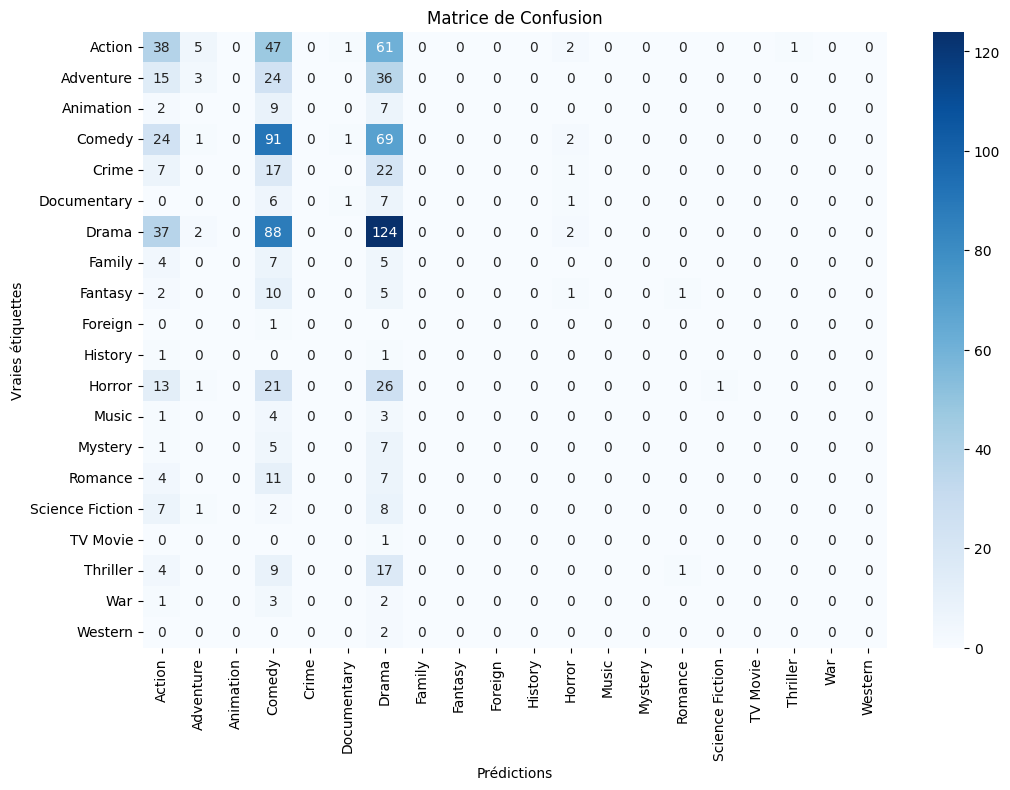

Rapport de classification :
                  precision    recall  f1-score   support

         Action       0.24      0.25      0.24       155
      Adventure       0.23      0.04      0.07        78
      Animation       0.00      0.00      0.00        18
         Comedy       0.26      0.48      0.34       188
          Crime       0.00      0.00      0.00        47
    Documentary       0.33      0.07      0.11        15
          Drama       0.30      0.49      0.37       253
         Family       0.00      0.00      0.00        16
        Fantasy       0.00      0.00      0.00        19
        Foreign       0.00      0.00      0.00         1
        History       0.00      0.00      0.00         2
         Horror       0.00      0.00      0.00        62
          Music       0.00      0.00      0.00         8
        Mystery       0.00      0.00      0.00        13
        Romance       0.00      0.00      0.00        22
Science Fiction       0.00      0.00      0.00        18
 

c:\Users\Augustin\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\Augustin\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\Augustin\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf

In [24]:
# Afficher la matrice de confusion
conf_matrix = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(12, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=clf.classes_, yticklabels=clf.classes_)
plt.title('Matrice de Confusion')
plt.xlabel('Prédictions')
plt.ylabel('Vraies étiquettes')
plt.show()

# Afficher le rapport de classification
class_report = classification_report(y_test, y_pred)
print("Rapport de classification :\n", class_report)